# 1. **Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. **Imports**

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, BatchNormalization, MaxPool1D, TimeDistributed, Flatten, GlobalMaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, Conv1D, Add, GRU, Concatenate, SpatialDropout1D, Bidirectional, Activation
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import activations
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
import pandas as pd
import re
import copy
import numpy as np
import os
import string 

import seaborn as sns
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
import matplotlib.pyplot as plt

PATH = "/content/drive/My Drive/NN-NLP/"

# 3. **Hyperparameters**

In [ ]:
MAX_LENGTH = 128
EMBEDDING_SIZE = 32
TRAIN_EPOCHS = 4
BATCH_SIZE = 64
LEARNING_RATE = 1e-2

# 4. **Upload Dataset**

In [ ]:
df = pd.read_csv("/content/drive/My Drive/NN-NLP/IMDB Dataset.csv")

In [ ]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# 5. **Preprocessing Reviews**

In [ ]:
preprocessed_df = copy.deepcopy(df)
preprocessed_df['review'] = preprocessed_df['review'].apply(lambda review: re.sub('<[^<]+?>', '', str(review)))
preprocessed_df['sentiment'] = preprocessed_df['sentiment'].replace('positive', 1)
preprocessed_df['sentiment'] = preprocessed_df['sentiment'].replace('negative', 0)

In [ ]:
preprocessed_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [ ]:
reviews = preprocessed_df['review'].to_numpy()
sentiments = preprocessed_df['sentiment'].to_numpy()

In [ ]:
print(reviews.shape)
print(sentiments.shape)

(50000,)
(50000,)


# 6. **Extract Information Reviews**

In [ ]:
lengths_reviews = [len(review) for review in reviews]

In [ ]:
print("Min lengths reviews: ", np.min(lengths_reviews))
print("Max lengths reviews: ", np.max(lengths_reviews))
print("Average lengths reviews: ", round(np.mean(lengths_reviews),3))
print("Median lengths reviews: ", np.median(lengths_reviews))
print("Standard deviation lengths reviews:", round(np.std(lengths_reviews),3))

Min lengths reviews:  32
Max lengths reviews:  13584
Average lengths reviews:  1285.191
Median lengths reviews:  953.0
Standard deviation lengths reviews: 971.146


In [ ]:
unique_words_all_reviews = set()

for review in reviews:
    words_review = [item.strip() for item in re.split("(\W+)", review) 
                                  if len(item.strip()) > 0 and item.strip() not in string.punctuation and
                                     item.strip()[0] not in string.punctuation]
    
    for word in words_review:
        unique_words_all_reviews.add(word)

num_unique_words = len(unique_words_all_reviews)

In [ ]:
print("Number unique words in reviews: ", num_unique_words)

Number unique words in reviews:  132196


# 7. **Tokenization**

In [ ]:
tokenizer = Tokenizer(num_words=num_unique_words)

In [ ]:
tokenizer.fit_on_texts(reviews) 
tokenized_reviews = tokenizer.texts_to_sequences(reviews)

In [ ]:
print(len(tokenized_reviews))

50000


# 8. **Data Split**

In [ ]:
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(np.array(tokenized_reviews),
                                                                                  sentiments,
                                                                                  test_size=0.5)


indexes_validation = np.random.choice(test_reviews.shape[0], int(test_reviews.shape[0] * 0.2), replace=False)
validation_reviews = test_reviews[indexes_validation]
validation_sentiments = test_sentiments[indexes_validation]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
print(train_reviews.shape)
print(validation_reviews.shape)
print(test_reviews.shape)

(25000,)
(5000,)
(25000,)


# 9. **Input Formatting**

In [ ]:
padded_train_reviews = pad_sequences(train_reviews, maxlen=MAX_LENGTH)
padded_validation_reviews = pad_sequences(validation_reviews, maxlen=MAX_LENGTH)
padded_test_reviews = pad_sequences(test_reviews, maxlen=MAX_LENGTH)

In [ ]:
print(padded_train_reviews.shape)
print(padded_validation_reviews.shape)
print(padded_test_reviews.shape)

(25000, 128)
(5000, 128)
(25000, 128)


# 10. **GRU Model**

In [ ]:
def create_model():
    initializer = he_normal()

    input_layer = Input(shape=(MAX_LENGTH,))

    x = Embedding(input_dim = num_unique_words, output_dim = EMBEDDING_SIZE, input_length = MAX_LENGTH)(input_layer)

    x = Bidirectional(GRU(units=32, return_sequences=True, dropout=0.2, kernel_regularizer=l2(1e-5), recurrent_dropout=0.2))(x)
    
    x = Dropout(0.2)(x) 
    x = GlobalMaxPooling1D()(x)

    x = Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=l2(1e-5))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)


    last_layer = Dense(1, activation='sigmoid')(x)

    model = Model(input_layer, last_layer)

    optimizer = RMSprop(learning_rate=LEARNING_RATE)
    loss = BinaryCrossentropy()
    metrics = ['accuracy']

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 32)           4230272   
                                                                 
 bidirectional (Bidirectiona  (None, 128, 64)          12672     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 64)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080  

# 11. **Training GRU Model**

In [ ]:
mcp = ModelCheckpoint(PATH + "model_gru.h5", save_best_only=True, monitor="val_accuracy", mode="max")

In [ ]:
history = History()

In [ ]:
with tf.device('/device:GPU:0'):
    model.fit(x=padded_train_reviews, y=train_sentiments, 
              validation_data=(padded_validation_reviews, validation_sentiments), 
              epochs=TRAIN_EPOCHS, 
              batch_size=BATCH_SIZE, 
              verbose=1, 
              callbacks=[mcp, history], 
              shuffle=True)

Epoch 1/4
391/391 [==============================] - 651s 2s/step - loss: 0.3590 - accuracy: 0.8458 - val_loss: 0.3761 - val_accuracy: 0.8498
Epoch 2/4
391/391 [==============================] - 638s 2s/step - loss: 0.2275 - accuracy: 0.9135 - val_loss: 0.3246 - val_accuracy: 0.8704
Epoch 3/4
391/391 [==============================] - 643s 2s/step - loss: 0.1579 - accuracy: 0.9441 - val_loss: 0.3055 - val_accuracy: 0.8800
Epoch 4/4
391/391 [==============================] - 643s 2s/step - loss: 0.1059 - accuracy: 0.9666 - val_loss: 0.3750 - val_accuracy: 0.8782


In [ ]:
np.save(os.path.join(PATH, 'GRU Model History.npy'), history.history)

# 12. **Evaluate model**

In [ ]:
model = load_model(PATH + "model_gru.h5")

In [ ]:
with tf.device('/device:GPU:0'):
    test_loss, test_acc = model.evaluate(padded_test_reviews, test_sentiments)
  
    print('Test Loss: %.5f' % test_loss)
    print('Test Accuracy: %.5f' % test_acc)

782/782 [==============================] - 69s 88ms/step - loss: 0.3115 - accuracy: 0.8764
Test Loss: 0.31149
Test Accuracy: 0.87644


# 13. **Plot Loss & Accuracy**

In [ ]:
history = np.load(os.path.join(PATH, 'GRU Model History.npy'), allow_pickle='TRUE').item()

In [ ]:
print(history)

{'loss': [0.35895130038261414, 0.22749312222003937, 0.15793316066265106, 0.1059277132153511], 'accuracy': [0.8457599878311157, 0.9135199785232544, 0.9441199898719788, 0.9665600061416626], 'val_loss': [0.3760891258716583, 0.32458817958831787, 0.3054748773574829, 0.37502622604370117], 'val_accuracy': [0.8497999906539917, 0.8704000115394592, 0.8799999952316284, 0.8781999945640564]}


In [ ]:
def create_plot():
    train_losses = history.get('loss')
    train_accuracies = history.get('accuracy')
    validation_losses = history.get('val_loss')
    validation_accuracies = history.get('val_accuracy')
    title_plot = "Training Analysis - GRU Model"

    figure, axs = plt.subplots(1, 2, figsize=(12, 7))

########################################################################################################################
# First plot #

    ax1 = axs[0]
    line_1 = ax1.plot(np.arange(len(train_losses)), train_losses, color='orange', linewidth=2, marker='o', label="Train Loss")

    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)

    ax1.set_xticks(np.around(np.arange(0, len(train_losses), step=1)))

    line_2 = ax1.plot(np.arange(len(validation_losses)), validation_losses, color='blue', linewidth=2, marker='s', label="Validation Loss")

    lines_second_plot = line_1 + line_2
    labels_lines_first_plot = [line.get_label() for line in lines_second_plot]

    ax1.legend(lines_second_plot, labels_lines_first_plot, loc=0, frameon=True, fontsize=14)
    ax1.set_title("Loss Comparison", fontsize=17)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

########################################################################################################################
# Second plot #

    ax2 = axs[1]
    line_3 = ax2.plot(np.arange(len(train_accuracies)), train_accuracies, color='orange', linewidth=2, marker='o', label="Train Accuracy")

    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)

    ax2.set_xticks(np.around(np.arange(0, len(train_accuracies), step=1)))

    line_4 = ax2.plot(np.arange(len(validation_accuracies)), validation_accuracies, color='blue', linewidth=2,  marker='s', label="Validation Accuracy")

    lines_second_plot = line_3 + line_4
    labels_lines_second_plot = [line.get_label() for line in lines_second_plot]

    ax2.legend(lines_second_plot, labels_lines_second_plot, loc=0, frameon=True, fontsize=14)
    ax2.set_title("Accuracy Comparison", fontsize=17)

    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title_plot, fontsize=20)
    plt.savefig(os.path.join(PATH, "Model GRU Plot.png"))
    #plt.show()

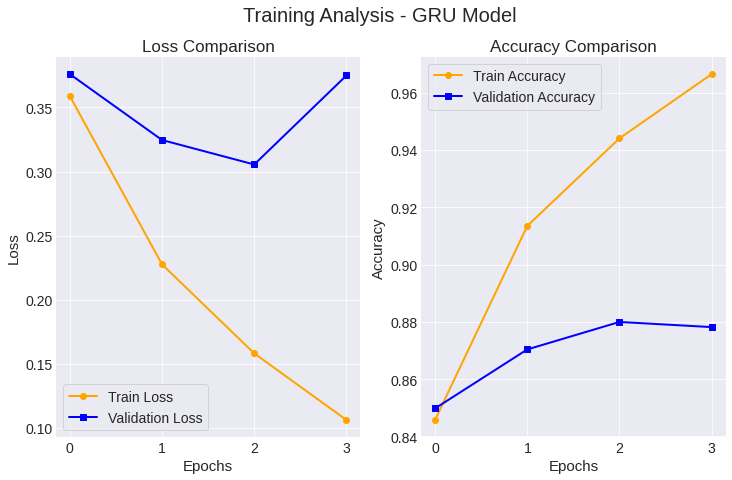

In [ ]:
create_plot()